In [288]:
import io
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import nltk
import heapq
import numpy as np
import re
import pandas as pd
from nltk.corpus.reader.conll import ConllCorpusReader, LazyConcatenation, LazyMap

In [289]:
# nltk.download('words')
# nltk.download('maxent_ne_chunker')

In [290]:
###Taken from [https://stackoverflow.com/questions/46872083/ne-tags-in-nltk-conllcorpusreader] [14/11/2022]
class betterConllReader(ConllCorpusReader):

    def iob_words(self, fileids=None, tagset=None, column="ne"):
        """
        :return: a list of word/tag/IOB tuples
        :rtype: list(tuple)
        :param fileids: the list of fileids that make up this corpus
        :type fileids: None or str or list
        """
        self._require(self.WORDS, self.POS, self.CHUNK, self.NE)
        def get_iob_words(grid):
            return self._get_iob_words(grid, tagset, column)
        return LazyConcatenation(LazyMap(get_iob_words, self._grids(fileids)))

    def _get_iob_words(self, grid, tagset=None, column="ne"):
        pos_tags = self._get_column(grid, self._colmap['pos'])
        if tagset and tagset != self._tagset:
            pos_tags = [map_tag(self._tagset, tagset, t) for t in pos_tags]
        return list(zip(self._get_column(grid, self._colmap['words']), pos_tags,
                   self._get_column(grid, self._colmap[column])))

###

In [317]:
def read_data(root_filename, datafiles, column_types):
    # data_stream = pyconll.load_from_file(filename)
    # data = parse(data_stream)

    data = betterConllReader(root_filename, datafiles, columntypes=column_types)
    return data


def extract_annotations(inputfile, annotationcolumn, delimiter='\t'):
    '''
    This function extracts annotations represented in the conll format from a file
    
    :param inputfile: the path to the conll file
    :param annotationcolumn: the name of the column in which the target annotation is provided
    :param delimiter: optional parameter to overwrite the default delimiter (tab)
    :type inputfile: string
    :type annotationcolumn: string
    :type delimiter: string
    :returns: the annotations as a list
    '''
    #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
    conll_input = pd.read_csv(inputfile, sep=delimiter, error_bad_lines=False)
    annotations = conll_input[annotationcolumn].tolist()
    return annotations


def get_class_labels_distribution(data, plot=False, train_data=True):
    labels_counter = defaultdict(int)

    for iob_word in data.iob_words(): 
        labels_counter[iob_word[-1]] += 1

#     del labels_counter["O"]
    
    if plot:
        plt.bar(list(labels_counter.keys()), list(labels_counter.values()))
        plt.title("Class label distribution for {}".format("training data" if train_data else "dev data"))
    
    return labels_counter

def get_top_k_items_from_dict(dict_, k):
    top_k_counter = defaultdict(str)

    for category_, inside_counter in dict_.items():
        k_keys_sorted = heapq.nlargest(k, inside_counter.items(), key=lambda x: x[1])
        top_k_counter[category_] = k_keys_sorted
    
    return top_k_counter

def get_top_k_words_per_category(data, k=5, category=None):
    words_counter = defaultdict(dict)
    
    for iob_word in data.iob_words():
        word = iob_word[0].lower()
        ne = iob_word[-1]
        if word not in words_counter[ne]:
            words_counter[iob_word[-1]].update({word: 1})
        else:
            words_counter[iob_word[-1]][word] += 1
            
    return get_top_k_items_from_dict(words_counter, k)            
    

def get_top_k_pos_per_category(data):
    pos_counter = defaultdict(dict)
    for iob_word in data.iob_words():
        pos_tag, ne = iob_word[1], iob_word[2]

        if bool(re.search("[a-zA-Z]+", pos_tag)):    
            if pos_tag not in pos_counter[ne]:
                pos_counter[ne].update({pos_tag: 1})
            else:
                pos_counter[ne][pos_tag] += 1
                
    return get_top_k_items_from_dict(pos_counter, k=5)

def plot_top_k_words(top_k_words):
    labels = list(top_k_words.keys())

    width = 0.35

    top_words = []
    top_words_count = []

    for label in labels:
        word, word_count = top_k_words[label][0]
        top_words.append(word)
        top_words_count.append(word_count)

    bar1 = plt.bar(labels, top_words_count)

    for i, rect in enumerate(bar1):
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, top_words[i], ha='center', va='bottom')
        
def plot_pos_disribution(top_k_pos_tag):
    class_labels = list(top_k_pos_tag.keys())

    width = 0.35
    fig, ax = plt.subplots(4,2, figsize=(10, 10))
    fig.tight_layout(pad=2.0)

    counter = 0
    for i in range(4):
        for j in range(2):
            class_label = class_labels[counter]
            x_labels, y_counts = [], []
            for x_label, y_count in top_k_pos_tag[class_label]:
                x_labels.append(x_label)
                y_counts.append(y_count)

            ax[i][j].bar(x_labels, y_counts)
            ax[i][j].title.set_text("POS distribution for {}".format(class_label))
            counter += 1
    plt.show()

In [300]:
root_filename = "../../data/"
datafiles = ["conll2003.train.conll", "conll2003.dev.conll"]
column_types = ["words", "pos", "chunk", "ne"]

In [307]:
train_data = read_data(root_filename, [datafiles[0]], column_types)
dev_data = read_data(root_filename, [datafiles[1]], column_types)

In [308]:
exploration_results = dict()
columns = []

## Data Exploration

### 1. Class label distribution

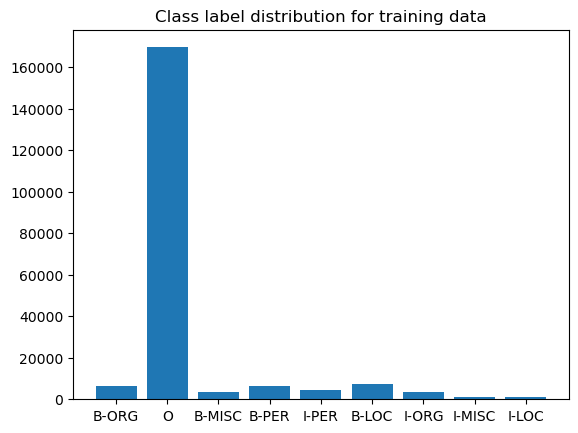

In [313]:
train_labels_counter = get_class_labels_distribution(train_data, plot=True, train_data=True)
exploration_results["entity count distribution train"] = train_labels_counter

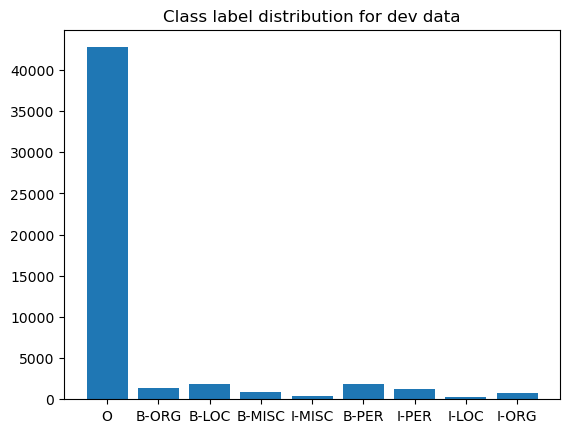

In [314]:
dev_labels_counter = get_class_labels_distribution(dev_data, plot=True, train_data=False)
exploration_results["entity count distribution dev"] = dev_labels_counter

### 2. Top words per  category

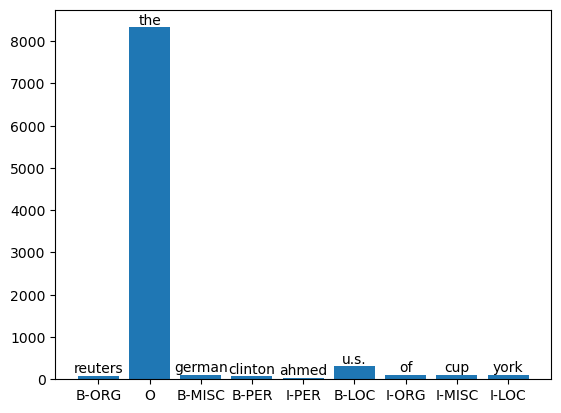

In [315]:
train_top_k_words = get_top_k_words_per_category(train_data, k=3)
plot_top_k_words(train_top_k_words)

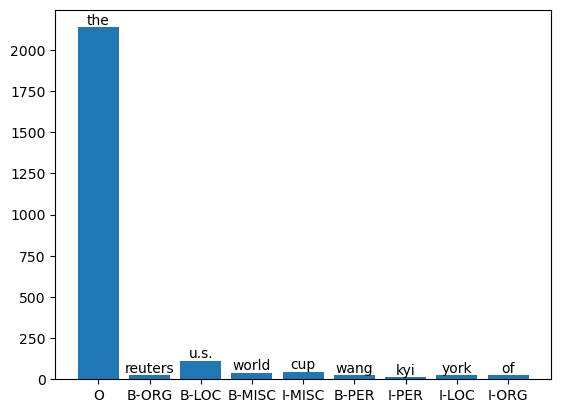

In [316]:
dev_top_k_words = get_top_k_words_per_category(dev_data, k=3)
plot_top_k_words(dev_top_k_words)

### 3. Exploration of given linguistic features like POS tags

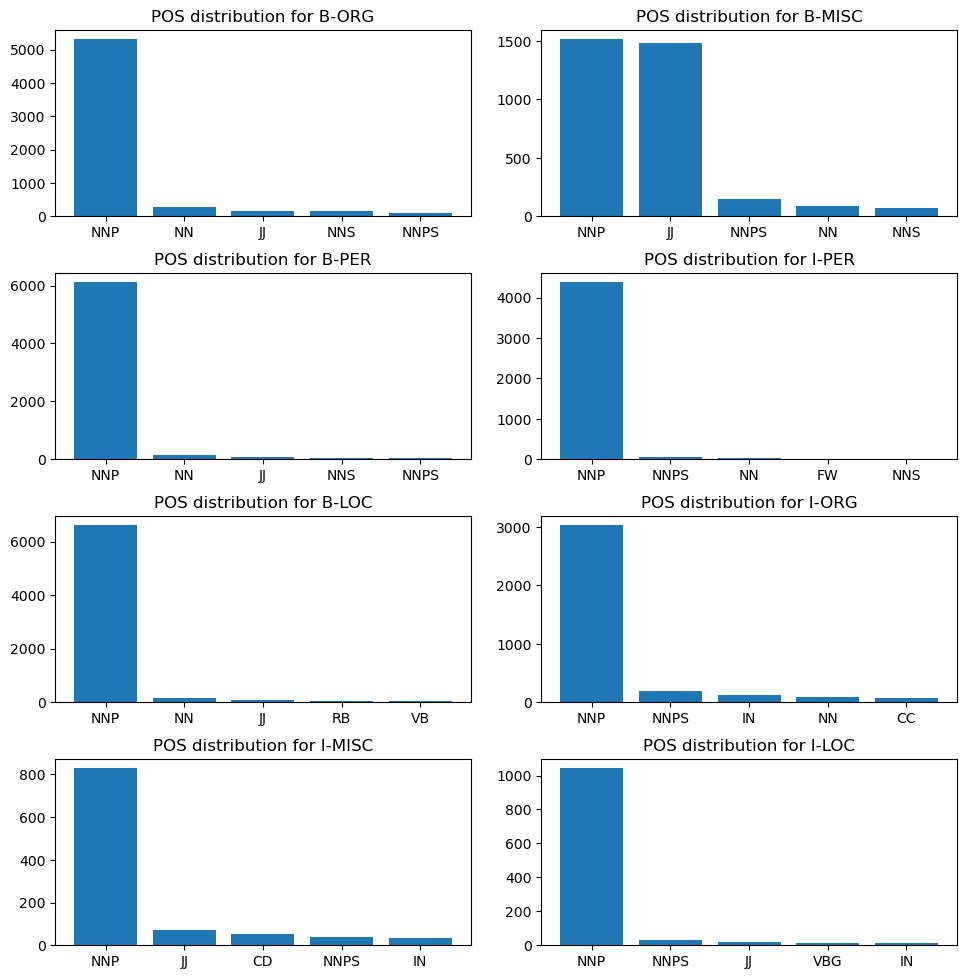

In [323]:
train_top_k_pos_tag = get_top_k_pos_per_category(train_data)
del train_top_k_pos_tag['O']

plot_pos_disribution(train_top_k_pos_tag)

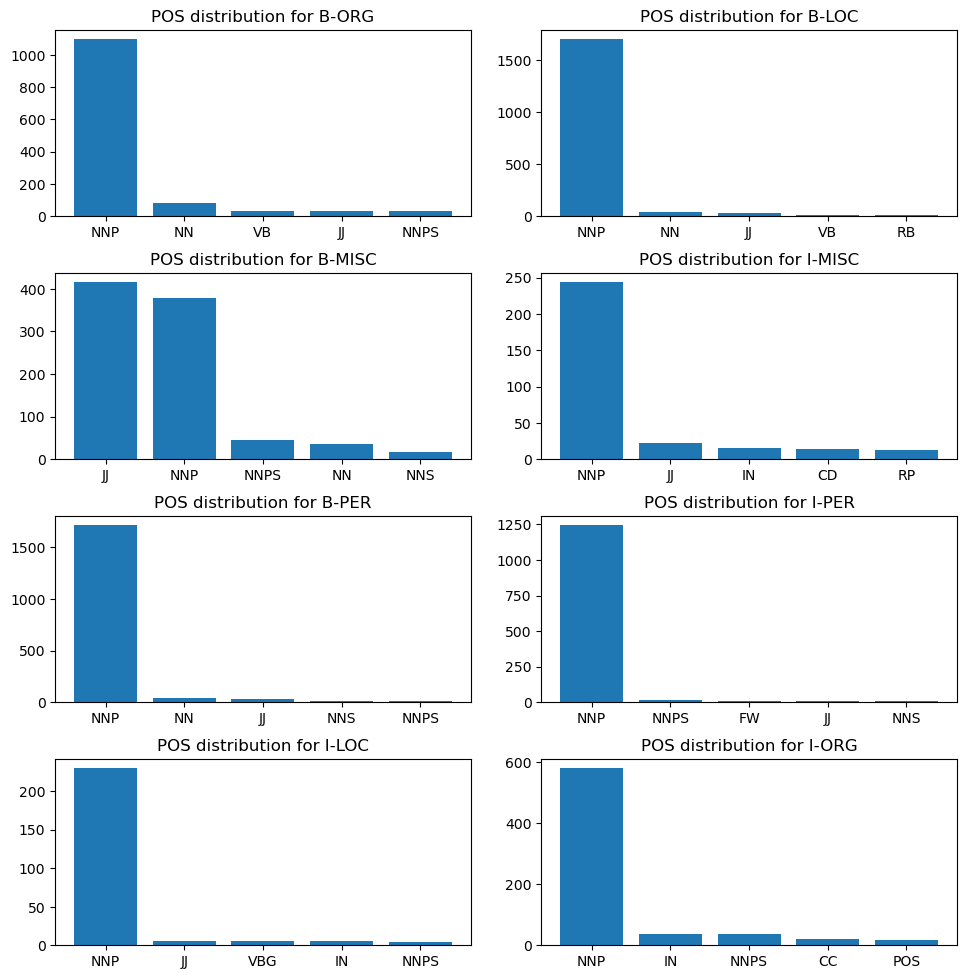

In [324]:
dev_top_k_pos_tag = get_top_k_pos_per_category(dev_data)
del dev_top_k_pos_tag['O']

plot_pos_disribution(dev_top_k_pos_tag)

### 4. Orthographic features distribution

In [258]:
## Getting a count of words that have the first letter capital for different classes

In [266]:
ortho_counter = defaultdict(int)
for sent in data.iob_sents():
    for iob_word in sent[1:]:
        if bool(re.search("^[A-Z]", iob_word[0])):
            ortho_counter[iob_word[-1]] += 1
            
del ortho_counter['O']

Text(0.5, 1.0, 'Distribution of words having first letter as Captial for different classes')

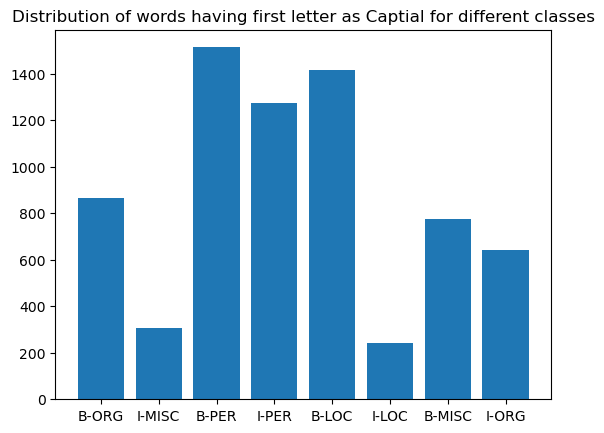

In [267]:
plt.bar(ortho_counter.keys(), ortho_counter.values())
plt.title("Distribution of words having first letter as Captial for different classes")

In [ ]:
## Features to use:
# 1. Word itself
# 2. POS tag one-hot vector
# 3. Capital
# 4. Is it the first word? This is being used to include the fact that first word of the sentence is always capital

In [292]:
a = {"labels": {"A": 2, "B": 3}, "labels2": {"A": 5, "B": 3}}
df = pd.DataFrame.from_dict(a)

In [293]:
df

,labels,labels2
A,2,5
B,3,3
